In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('./train.csv')

---

# Part 1: Data Validation
## This section will be checking for outliers and data entry errors

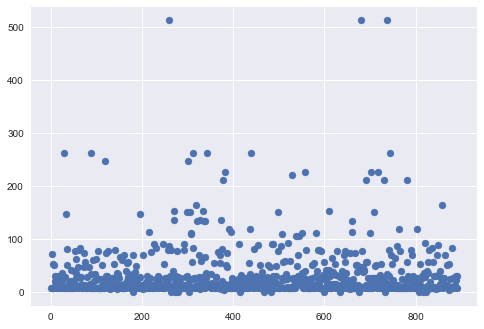

In [3]:
#you can see there are three passengers with tickets that cost almost double the other passengers.
#i will be removing them from the train dataset later

plt.scatter(x=data['PassengerId'], y=data['Fare'])
plt.show()

In [4]:
#check that sex is only male or female

data['Sex'].unique()

array(['male', 'female'], dtype=object)

In [5]:
#check for the least amount of people in a cabin. 
#i noticed that embarked was 0 so i took a closer look

data.groupby([data['Cabin']]).agg({'count'}).min()

PassengerId  count    1
Survived     count    1
Pclass       count    1
Name         count    1
Sex          count    1
Age          count    0
SibSp        count    1
Parch        count    1
Ticket       count    1
Fare         count    1
Embarked     count    0
dtype: int64

In [6]:
#two people that bought the same ticket never boarded the boat
#since there life was not in danger, they will be removed from the dataset
#also note that Names have salutations

data[data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [7]:
# lots of null ages, will impute values later

data[data['Age'].isnull()].count()

PassengerId    177
Survived       177
Pclass         177
Name           177
Sex            177
Age              0
SibSp          177
Parch          177
Ticket         177
Fare           177
Cabin           19
Embarked       177
dtype: int64

In [8]:
#210 people have duplicate ticket numbers
#I will be de-duping and keeping the first occurance of each ticket

data[data['Ticket'].duplicated()].count()

PassengerId    210
Survived       210
Pclass         210
Name           210
Sex            210
Age            180
SibSp          210
Parch          210
Ticket         210
Fare           210
Cabin           67
Embarked       209
dtype: int64

---

# Part 2: Data Cleaning & Feature Engineering

In [9]:
#remove passengers with fares that will skew results
data = data[data['Fare']<500]

#remove passengers that never embarked
data = data[~data['Embarked'].isnull()]

#drop duplicate ticket numbers and keep whoever appears first for the ticket number in dataframe
data = data.drop_duplicates(subset=['Ticket'], keep='first')

#reset index
data = data.reset_index(drop=True)

In [10]:
#extract salutations
#this will allow us to go deeper than gender, we can see martitual status as well

data['Prefix']=data['Name'].str.extract('([A-Za-z]+)\.')

#fix some prefixes. all are correct, but some mean the same thing

data.replace({'Prefix' : {'Mme':'Miss', 'Mlle':'Miss', 'Lady':'Mrs', 'Ms':'Miss'}},inplace=True)

In [11]:
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values="NaN", strategy="mean")
data["Age"]=imp.fit_transform(data[["Age"]]).ravel()

In [12]:
# create buckets for age groups

data['AgeGroup'] = pd.cut(data['Age'], [0,18,36,54,72,90], labels=[1,2,3,4,5], include_lowest=True)

In [13]:
# convert to numerical categories

cats = ['Name', 'Ticket', 'Cabin', 'Embarked', 'Sex', 'Pclass', 'Prefix']

for x in cats:
    data[x] = data[x].astype('category').cat.codes
    data[x] = data[x].astype('category')

---

# Part 3: Exploratory Data Analysis

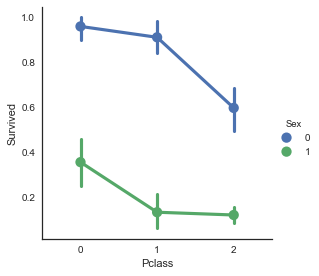

In [14]:
#visualizes that sex plays a factor in survival
#also shows that the 'higher' classes had a lesser chance of survival
#blue is female, green is male

sns.set_style('white')
x = sns.factorplot('Pclass','Survived',hue='Sex',data=data)
plt.show()

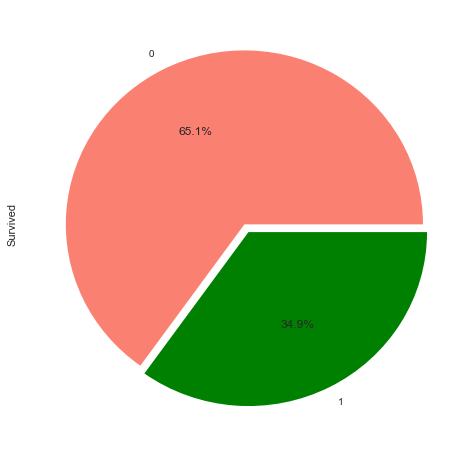

In [15]:
#about 2/3 of the passengers did not survive

plt.rcParams['figure.figsize'] = 8,8

data['Survived'].value_counts().plot.pie(autopct='%1.1f%%', shadow=False, explode = (0, 0.05),\
                                          colors=['salmon', 'green'])
plt.show()

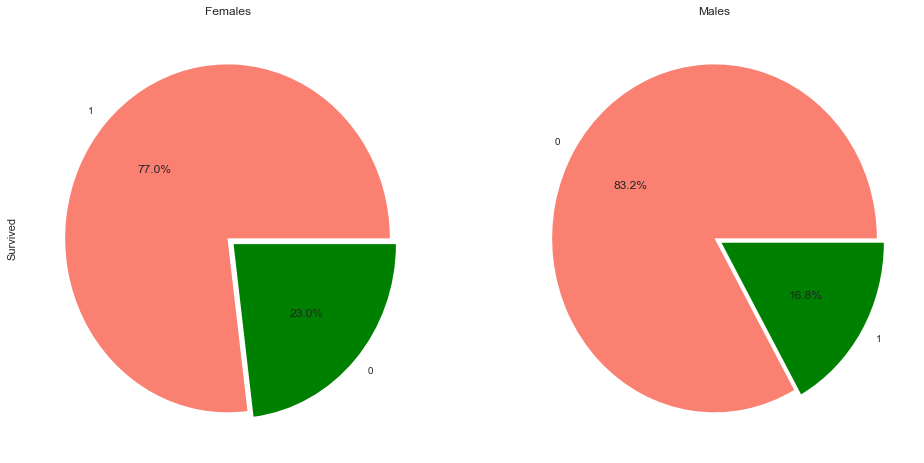

In [16]:
#within each gender, roughly the life/death ratio is similar

f, ax = plt.subplots(1,2, figsize=(16,8), sharey=True)

data[data['Sex']==0]['Survived'].value_counts().plot.pie(autopct='%1.1f%%', shadow=False, explode = (0, 0.05),\
                                          colors=['salmon', 'green'], ax=ax[0], title='Females')
data[data['Sex']==1]['Survived'].value_counts().plot.pie(autopct='%1.1f%%', shadow=False, explode = (0, 0.05),\
                                          colors=['salmon', 'green'], ax=ax[1], title='Males')
plt.show()

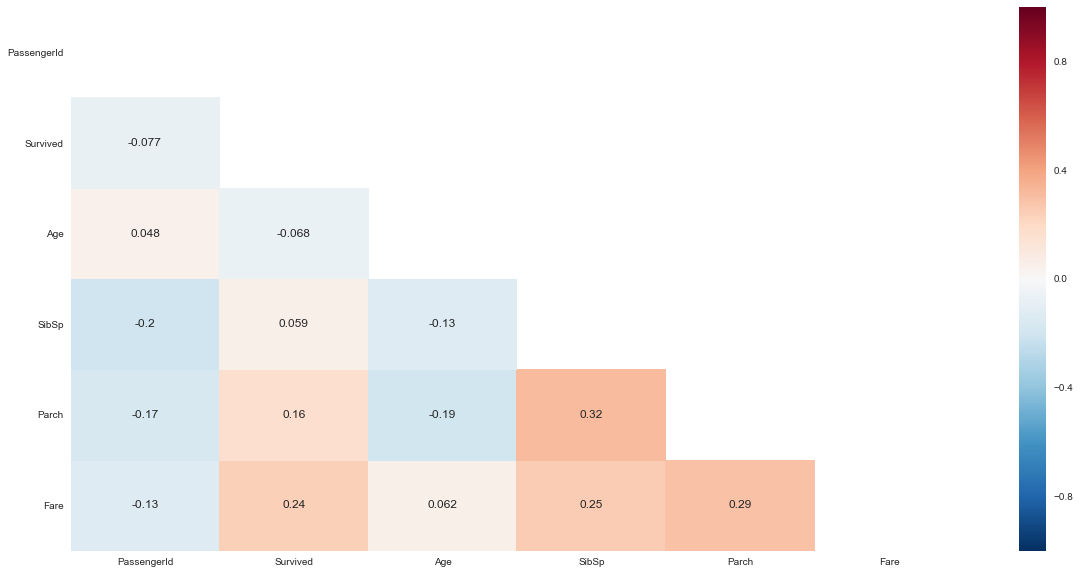

In [17]:
#heatmap of correllation
#because i categorized as numbers, some show a negative correllation which would mean there is an inverse relationship
#this should be ignored in some cases, for example, Fare and Pclass show a -0.6 correllation, when in reality, we
#know they are correllated

plt.rcParams['figure.figsize'] = 20,10
cor = data.corr()
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True


x = sns.heatmap(cor, annot=True, mask=mask)
plt.setp(x.get_yticklabels(), rotation=360)
plt.show()

# Part 4: Machine Learning - Train and Test
## Predict if a passenger lives or dies

In [18]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [19]:
#create variables for our target and our variables

varCols = data.columns.drop('Survived')
X = data[varCols]
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### I would use the AdaBoostClassifier in production. It is tied with the RandomForestClassifier for the best score, but it has the lowest standard deviation of all models tested.

RFC: 0.814572 (0.066943)
ABC: 0.814572 (0.061557)
GPC: 0.646613 (0.091336)
GNB: 0.789706 (0.067886)
KNN: 0.640686 (0.068507)
DTC: 0.745232 (0.077340)
GBC: 0.785205 (0.102216)


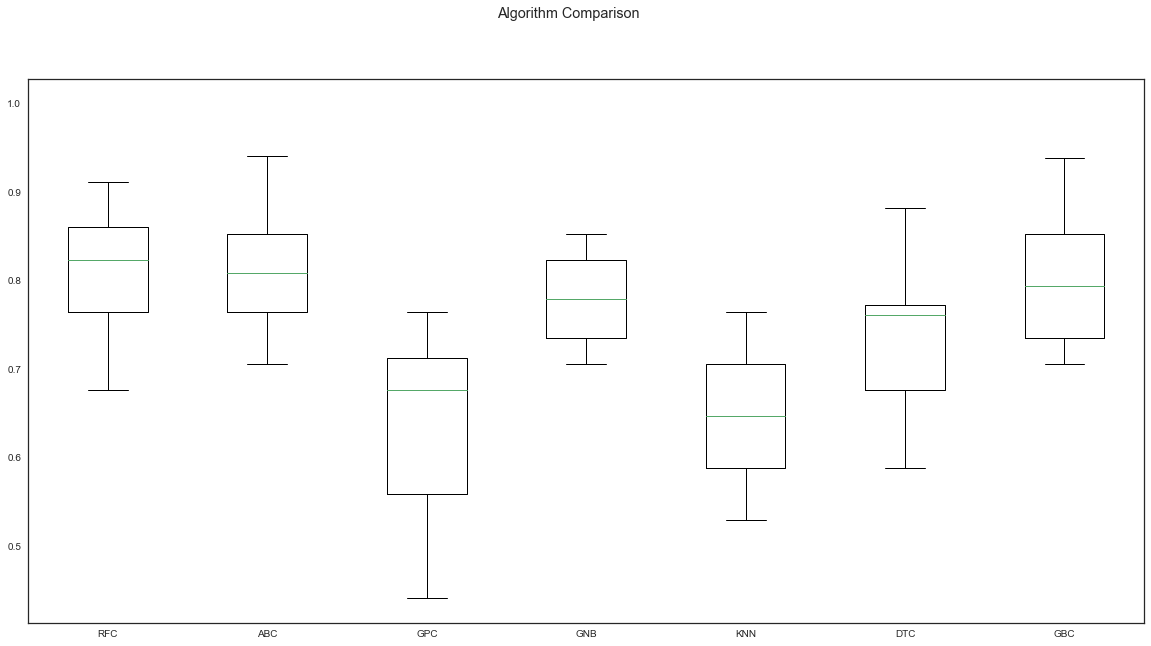

In [20]:
# prepare configuration for cross validation test harness
seed = 10

# prepare models
models = []
models.append(('RFC', RandomForestClassifier(n_jobs=-1, n_estimators=175)))
models.append(('ABC', AdaBoostClassifier(n_estimators=150)))
models.append(('GPC', GaussianProcessClassifier(n_jobs=-1)))
models.append(('GNB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
models.append(('DTC', DecisionTreeClassifier(criterion='entropy')))
models.append(('GBC', GradientBoostingClassifier(max_depth=10, n_estimators=200)))

# evaluate each model 
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=20, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    res = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(res)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()